# Closing Price Prediction with LSTM

In this notebook, we only consider the time series consisting of daily closing prices. The information of daily opening, lowest and highest price is not used.

In [104]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from torchviz import make_dot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import mplfinance as mpf

## Data Processing

In [70]:
DATA_DIR = "../../data"
stocks = pd.read_csv(os.path.join(DATA_DIR, "stocks.csv"), index_col=0, parse_dates=True)
stocks.head(5)

,Company,Sector,Open,High,Low,Close,Volume
Date,,,,,,,
2017-11-02,AAPL,Technology,41.650002,42.125000,41.320000,42.027500,165573600
2017-11-03,AAPL,Technology,43.500000,43.564999,42.779999,43.125000,237594400
2017-11-06,AAPL,Technology,43.092499,43.747501,42.930000,43.562500,140105200
2017-11-07,AAPL,Technology,43.477501,43.812500,43.400002,43.702499,97446000
2017-11-08,AAPL,Technology,43.665001,44.060001,43.582500,44.060001,97638000


We choose to analyze the Apple company.

In [71]:
apple = stocks[stocks["Company"] == "AAPL"]
apple.head()

,Company,Sector,Open,High,Low,Close,Volume
Date,,,,,,,
2017-11-02,AAPL,Technology,41.650002,42.125000,41.320000,42.027500,165573600
2017-11-03,AAPL,Technology,43.500000,43.564999,42.779999,43.125000,237594400
2017-11-06,AAPL,Technology,43.092499,43.747501,42.930000,43.562500,140105200
2017-11-07,AAPL,Technology,43.477501,43.812500,43.400002,43.702499,97446000
2017-11-08,AAPL,Technology,43.665001,44.060001,43.582500,44.060001,97638000


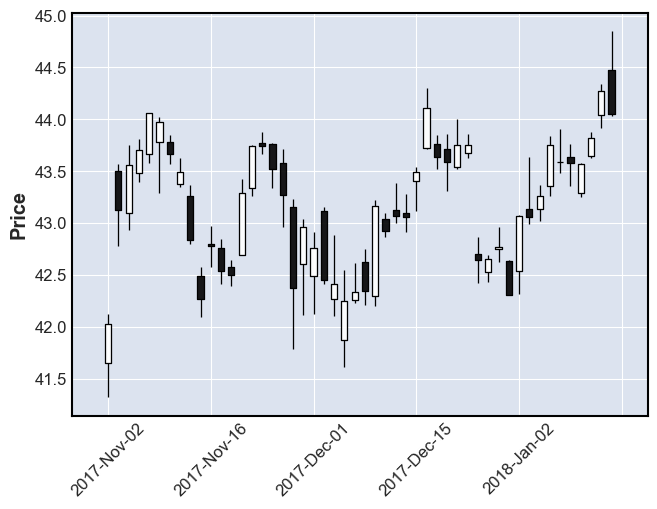

In [72]:
mpf.plot(apple.head(50), type="candle")

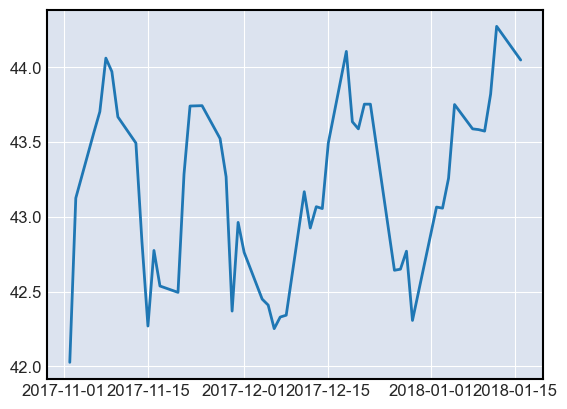

In [73]:
plt.plot(apple["Close"].head(50))
plt.show()

In [74]:
begin = 0
num_days = 150
end = begin + num_days
closing_prices = apple.iloc[begin : end]["Close"].to_numpy()
closing_prices

array([42.02750015, 43.125     , 43.5625    , 43.70249939, 44.06000137,
       43.97000122, 43.66749954, 43.49250031, 42.83499908, 42.27000046,
       42.77500153, 42.53749847, 42.49499893, 43.28499985, 43.74000168,
       43.74250031, 43.52249908, 43.26750183, 42.36999893, 42.96250153,
       42.76250076, 42.45000076, 42.40999985, 42.25249863, 42.33000183,
       42.34249878, 43.16749954, 42.92499924, 43.06750107, 43.05500031,
       43.49250031, 44.10499954, 43.63499832, 43.58750153, 43.75249863,
       43.75249863, 42.64250183, 42.65000153, 42.77000046, 42.30749893,
       43.06499863, 43.05749893, 43.25749969, 43.75      , 43.58750153,
       43.58250046, 43.57249832, 43.81999969, 44.27249908, 44.04750061,
       44.77500153, 44.81499863, 44.61500168, 44.25      , 44.25999832,
       43.55500031, 42.77750015, 42.87749863, 41.99000168, 41.74250031,
       41.85749817, 41.94499969, 40.125     , 39.12250137, 40.75749969,
       39.88499832, 38.78749847, 39.10250092, 40.67750168, 41.08

In [75]:
def make_batches(seq: np.ndarray, window_size: int) -> np.ndarray:
    return np.array([
        seq[i : i+window_size]
        for i in range(len(seq) - window_size)
    ])

L = 10
window_size = L + 1
batches = make_batches(closing_prices, window_size)
batches

array([[42.02750015, 43.125     , 43.5625    , ..., 42.83499908,
        42.27000046, 42.77500153],
       [43.125     , 43.5625    , 43.70249939, ..., 42.27000046,
        42.77500153, 42.53749847],
       [43.5625    , 43.70249939, 44.06000137, ..., 42.77500153,
        42.53749847, 42.49499893],
       ...,
       [46.90750122, 46.79000092, 47.09000015, ..., 47.56000137,
        47.95750046, 48.32749939],
       [46.79000092, 47.09000015, 47.03749847, ..., 47.95750046,
        48.32749939, 48.49499893],
       [47.09000015, 47.03749847, 47.14500046, ..., 48.32749939,
        48.49499893, 48.36500168]])

### Scaling the Data

In [76]:
scaler = MinMaxScaler(feature_range=(-1, 1))
batches = scaler.fit_transform(batches)

### Training and Test Datasets

In [77]:
test_size = 0.1
split = int(len(batches) * (1 - test_size))
train_ds = batches[:split, :]
test_ds = batches[split:, :]

x_train = train_ds[:, :-1].reshape(-1, L, 1)
y_train = train_ds[:, -1].reshape(-1, 1)
x_test = test_ds[:, :-1].reshape(-1, L, 1)
y_test = test_ds[:, -1].reshape(-1, 1)

x_train.shape, y_train.shape

((125, 10, 1), (125, 1))

### Converting to Tensors

In [78]:
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test)

In [79]:
x_train_tensor.shape

torch.Size([125, 10, 1])

## Model Construction

### Class Definition

In [80]:
class LSTM(nn.Module):

    def __init__(self,
                 input_size: int, hidden_size: int,
                 num_layers: int, output_size: int):
        # initialize super class
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        # LSTM layer
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)

        # fully connected layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad = True)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad = True)

        # output has shape (N, L, H)
        # h_n has shape (num_layers, N, H)
        #
        # where N is the batch size
        # L is the sequence length
        # and H is the hidden size
        # output, (h_n, c_n) = self.lstm.forward(x, (h0.detach(), c0.detach()))
        output, (h_n, c_n) = self.lstm.forward(x)

        # in fact, we want the last hidden value
        # from the last LSTM layer, i.e., h_n[-1, :, :]
        h = h_n[-1, :, :]

        # get predicted value from
        # the fully connected layer
        y = self.fc.forward(h)

        return y

### Summary

In [96]:
model = LSTM(
    input_size=1,
    hidden_size=16,
    num_layers=1,
    output_size=1
)
model

LSTM(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

### Optimizer and Loss Function

In [97]:
criterion = nn.MSELoss(reduction='mean')
optimiser = optim.Adam(model.parameters(), lr=0.01)

## Training and Testing

In [98]:
epochs = 100
for i in range(epochs):
    y_hat = model.forward(x_train_tensor)

    # calculate loss
    loss = criterion(y_hat, y_train_tensor)
    print(f"epoch:\t{i}\tloss:\t{loss}")

    # clear gradients
    optimiser.zero_grad()

    # compute gradients through backward propagation
    loss.backward()

    # update parameters
    optimiser.step()

epoch:	0	loss:	0.1364826112985611
epoch:	1	loss:	0.12237481772899628
epoch:	2	loss:	0.11072055995464325
epoch:	3	loss:	0.10148898512125015
epoch:	4	loss:	0.09528540819883347
epoch:	5	loss:	0.0925435721874237
epoch:	6	loss:	0.09051937609910965
epoch:	7	loss:	0.08568497747182846
epoch:	8	loss:	0.078559510409832
epoch:	9	loss:	0.071331687271595
epoch:	10	loss:	0.0655120313167572
epoch:	11	loss:	0.06145511940121651
epoch:	12	loss:	0.05836210772395134
epoch:	13	loss:	0.054579149931669235
epoch:	14	loss:	0.049427423626184464
epoch:	15	loss:	0.04443599656224251
epoch:	16	loss:	0.04160083457827568
epoch:	17	loss:	0.03906857967376709
epoch:	18	loss:	0.0344359390437603
epoch:	19	loss:	0.02944212593138218
epoch:	20	loss:	0.02618364989757538
epoch:	21	loss:	0.024615004658699036
epoch:	22	loss:	0.023896392434835434
epoch:	23	loss:	0.02382640354335308
epoch:	24	loss:	0.024286551401019096
epoch:	25	loss:	0.024388382211327553
epoch:	26	loss:	0.02359675243496895
epoch:	27	loss:	0.022333065047860146
epo

In [99]:
y_pred = model.forward(x_test_tensor).data.numpy()
y_pred

array([[0.60872847],
       [0.5707164 ],
       [0.6128308 ],
       [0.60311097],
       [0.6487646 ],
       [0.65329605],
       [0.67362463],
       [0.65360445],
       [0.63300925],
       [0.6016001 ],
       [0.7263776 ],
       [0.82190186],
       [0.9102862 ],
       [0.9703564 ]], dtype=float32)

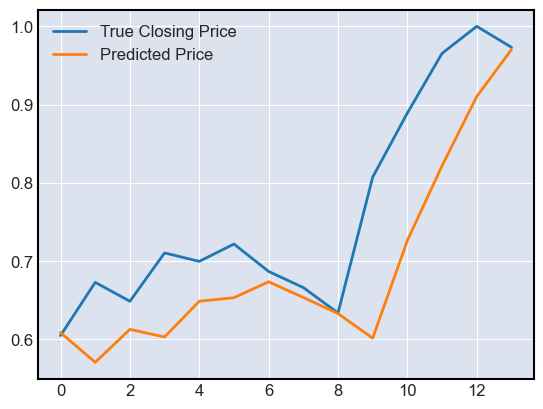

In [100]:
t = np.arange(len(y_pred))
plt.plot(t, y_test, label="True Closing Price")
plt.plot(t, y_pred, label="Predicted Price")
plt.legend()
plt.show()

In [105]:
mean_squared_error(y_test, y_pred)

0.009176322623955522